In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

import os
path_wd='./drive/MyDrive/MineriaIII'
os.chdir(path_wd)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import re
import tensorflow as tf
import keras
import pandas as pd
import cv2

path_models='models/'
path_pred='predictions/'
path_data='Sentinel2LULC_354/'
path_test='Test 2/'
ext_sub = '.csv'

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import save_model, load_model

In [4]:
data = []
labels = []
labelnames = {}

for d in os.listdir(path_data):
    lab = int(re.search('\d{1,2}', d).group())
    labelnames[str(lab)] = re.search('_+([a-zA-Z]+)_+', d).group(1)
    for f in os.listdir(path_data + d):
        try:
            img = cv2.imread(path_data + d + '/' + f)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            data.append(img)
            labels.append(lab)
        except:
            print("Cannot read file: " + d + '/' + f)

data = np.array(data)
labels = np.array(labels)

In [5]:
train, val = train_test_split(np.arange(len(labels)), test_size=0.1, random_state=21, stratify=labels)
train_data = data[train]
train_labels = labels[train]
val_data = data[val]
val_labels = labels[val]

In [6]:
test_data = []
test_labels = []
test_ids = []

for f in os.listdir(path_test):
    lab = int(re.search('^(\d{1,2})_', f).group(1))
    try:
        img = cv2.imread(path_test + f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_data.append(img)
        test_labels.append(lab)
        test_ids.append(f)
    except:
        print("Cannot read file: " + f)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [7]:
batch_size = 32
shuffle_buffer_size = 1000

nclasses = len(np.unique(labels))
img_shape = data.shape[1:4]

train_labels_coded = tf.one_hot(train_labels-1, depth=nclasses, on_value=1, off_value=0)
val_labels_coded = tf.one_hot(val_labels-1, depth=nclasses, on_value=1, off_value=0)
test_labels_coded = tf.one_hot(test_labels-1, depth=nclasses, on_value=1, off_value=0)

data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
      tf.keras.layers.experimental.preprocessing.RandomContrast(0.5)
  ])

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_data), tf.convert_to_tensor(train_labels_coded)))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))
val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(val_data), tf.convert_to_tensor(val_labels_coded)))
test_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(test_data), tf.convert_to_tensor(test_labels_coded)))

train_batches = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
val_batches = val_dataset.batch(batch_size)
test_batches = test_dataset.batch(batch_size)

In [8]:
def create_model(base_model):
  base_model.trainable = False
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(nclasses)
  ])
  return model


def train_evaluate_model(model, name, lr=0.0001):
  earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    verbose=1,
    mode='max',
    patience=5,
    restore_best_weights=True
  )
  epochs = 50
  #optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  metrics = [tf.keras.metrics.categorical_accuracy]

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  history = model.fit(train_batches,
                      epochs=epochs, 
                      validation_data=val_batches,
                      callbacks=[earlystopping])
  save_model(model, path_models + name + '.h5')

  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,(np.max(val_loss)+0.01)])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

  test_loss, test_acc = model.evaluate(test_batches)
  print('Test loss: ' + str(test_loss) + ', test acc: ' + str(test_acc))
  
  val_preds = np.argmax(model.predict(val_data), axis=-1)
  val_matrix = tf.math.confusion_matrix(val_labels-1, val_preds)
  test_preds = np.argmax(model.predict(test_data), axis=-1)
  test_matrix = tf.math.confusion_matrix(test_labels-1, test_preds)

  fig, ax = plt.subplots(1, 2, figsize=(10,20))
  axlabs = [str(l) for l in np.unique(np.sort(train_labels))]

  im = ax[0].imshow(val_matrix)
  ax[0].set_xticks(np.arange(nclasses))
  ax[0].set_yticks(np.arange(nclasses))
  ax[0].set_xticklabels(axlabs)
  ax[0].set_yticklabels(axlabs)
  ax[0].set_title("Validation conf matrix")

  im = ax[1].imshow(test_matrix)
  ax[1].set_xticks(np.arange(nclasses))
  ax[1].set_yticks(np.arange(nclasses))
  ax[1].set_xticklabels(axlabs)
  ax[1].set_yticklabels(axlabs)
  ax[1].set_title("Test confusion matrix")

  plt.show()
  
  
def prep_finetuning(model, from_layer):
  model.layers[0].trainable = True
  for layer in model.layers[0].layers[:from_layer]:
    layer.trainable =  False


def predictions_file(model, file='predictions'):
  predictions = model.predict(test_data)
  preds = np.argmax(predictions, axis=-1) + 1
  output = pd.DataFrame({'id.jpg': test_ids, 'label':preds})
  output.to_csv(path_pred + file + '.csv', header=True, index=False)

In [ ]:
base = tf.keras.applications.vgg19.VGG19(include_top = False, weights='imagenet',
                                         input_shape=img_shape, pooling='avg')
model_avgg = create_model(base)
train_evaluate_model(model_avgg, 'avgg19_256_128_aug')

80150528/80134624 [==============================] - 2s 0us/step
Epoch 1/50
287/287 [==============================] - 186s 544ms/step - loss: 2.5248 - categorical_accuracy: 0.3110 - val_loss: 1.9003 - val_categorical_accuracy: 0.4980
Epoch 2/50
287/287 [==============================] - 156s 521ms/step - loss: 1.7029 - categorical_accuracy: 0.5167 - val_loss: 1.4659 - val_categorical_accuracy: 0.5727
Epoch 3/50
287/287 [==============================] - 155s 521ms/step - loss: 1.3988 - categorical_accuracy: 0.5908 - val_loss: 1.2608 - val_categorical_accuracy: 0.6297
Epoch 4/50
287/287 [==============================] - 155s 521ms/step - loss: 1.2429 - categorical_accuracy: 0.6225 - val_loss: 1.1391 - val_categorical_accuracy: 0.6640
Epoch 5/50
287/287 [==============================] - 156s 522ms/step - loss: 1.1259 - categorical_accuracy: 0.6515 - val_loss: 1.0540 - val_categorical_accuracy: 0.6857
Epoch 6/50
287/287 [==============================] - 155s 520ms/step - loss: 1.0498 

In [ ]:
m_avgg = load_model(path_models + 'avgg19_256_128_aug.h5')
prep_finetuning(m_avgg, 20)
train_evaluate_model(m_avgg, 'avgg19_256_128_aug_v2', 0.00001)

In [ ]:
for name in os.listdir(path_models):
  m = load_model(path_models + name)
  test_loss, test_acc = m.evaluate(test_batches)
  print(name + ": loss = " + str(test_loss) + ", acc = " + str(test_acc))

Epoch 1/50
287/287 [==============================] - 191s 591ms/step - loss: 0.7426 - categorical_accuracy: 0.7604 - val_loss: 0.7290 - val_categorical_accuracy: 0.7770
Epoch 2/50
287/287 [==============================] - 170s 570ms/step - loss: 0.5862 - categorical_accuracy: 0.8035 - val_loss: 0.7126 - val_categorical_accuracy: 0.7829
Epoch 3/50
287/287 [==============================] - 170s 572ms/step - loss: 0.5212 - categorical_accuracy: 0.8236 - val_loss: 0.6460 - val_categorical_accuracy: 0.8114
Epoch 4/50
287/287 [==============================] - 169s 568ms/step - loss: 0.4697 - categorical_accuracy: 0.8396 - val_loss: 0.6914 - val_categorical_accuracy: 0.7917
Epoch 5/50
287/287 [==============================] - 169s 570ms/step - loss: 0.4618 - categorical_accuracy: 0.8350 - val_loss: 0.6244 - val_categorical_accuracy: 0.8065
Epoch 6/50
287/287 [==============================] - 170s 572ms/step - loss: 0.4285 - categorical_accuracy: 0.8465 - val_loss: 0.6061 - val_categoric

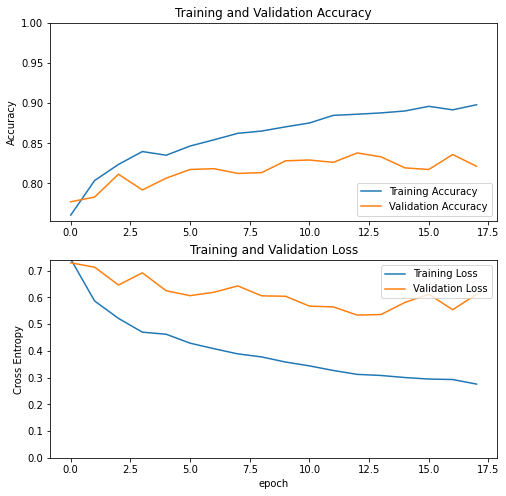

51/51 [==============================] - 20s 380ms/step - loss: 0.3936 - categorical_accuracy: 0.8881
Test loss: 0.39355209469795227, test acc: 0.8881335258483887


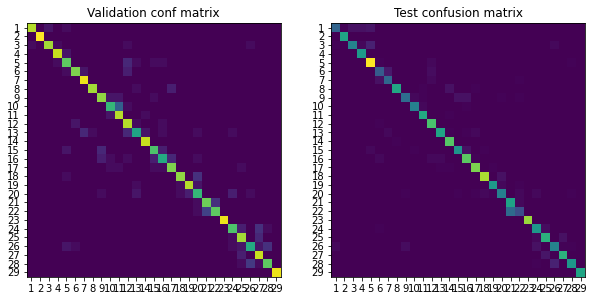

In [ ]:
m_avgg = load_model(path_models + 'avgg19_256_128_v2.h5')
prep_finetuning(m_avgg, 18)
train_evaluate_model(m_avgg, 'avgg19_256_128_v3', 0.00001)

Epoch 1/50
287/287 [==============================] - 183s 565ms/step - loss: 0.3239 - categorical_accuracy: 0.8858 - val_loss: 0.6131 - val_categorical_accuracy: 0.8094
Epoch 2/50
287/287 [==============================] - 163s 548ms/step - loss: 0.3126 - categorical_accuracy: 0.8846 - val_loss: 0.5890 - val_categorical_accuracy: 0.8242
Epoch 3/50
287/287 [==============================] - 163s 549ms/step - loss: 0.2892 - categorical_accuracy: 0.8952 - val_loss: 0.5767 - val_categorical_accuracy: 0.8212
Epoch 4/50
287/287 [==============================] - 163s 548ms/step - loss: 0.3036 - categorical_accuracy: 0.8943 - val_loss: 0.5920 - val_categorical_accuracy: 0.8124
Epoch 5/50
287/287 [==============================] - 163s 548ms/step - loss: 0.2731 - categorical_accuracy: 0.9021 - val_loss: 0.5370 - val_categorical_accuracy: 0.8330
Epoch 6/50
287/287 [==============================] - 164s 550ms/step - loss: 0.2741 - categorical_accuracy: 0.9014 - val_loss: 0.5485 - val_categoric

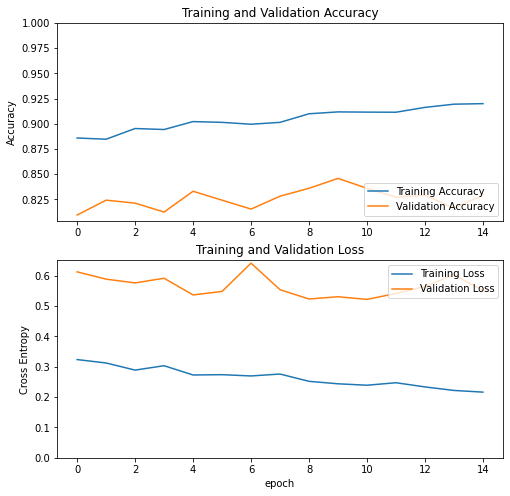

51/51 [==============================] - 18s 356ms/step - loss: 0.3623 - categorical_accuracy: 0.9030
Test loss: 0.36227768659591675, test acc: 0.9029666185379028


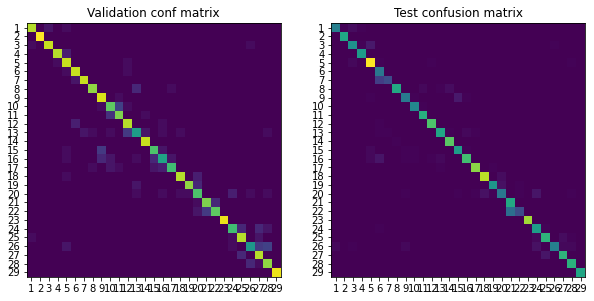

In [9]:
m_avgg = load_model(path_models + 'avgg19_256_128_v3.h5')
prep_finetuning(m_avgg, 18)
train_evaluate_model(m_avgg, 'avgg19_256_128_v4', 0.00001)

In [10]:
m_pred = load_model(path_models + 'avgg19_256_128_v4.h5')
predictions_file(m_pred, 'avgg19_256_128_v4')

In [ ]:
m_avgg_v4 = load_model(path_models + 'avgg19_256_128_v4.h5')
prep_finetuning(m_avgg_v4, 17)
train_evaluate_model(m_avgg_v4, 'avgg19_256_128_v5', 0.00001)